# Galaxy Classification, Anomaly Detection, Autoencoder & VAE (Keras)
This notebook uses the Galaxy10 DECaLS dataset (astronomical galaxy images) for:

1. Data loading & splitting, defining an anomaly class  
2. CNN classifier + ROC curves & confusion matrices  
3. Convolutional autoencoder for anomaly detection  
4. Variational autoencoder (VAE) + galaxy generation

Dataset: Galaxy10 DECaLS (HDF5).


In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random

import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## 1. Download the dataset, inspect classes, create anomaly split

Steps:
- Download `Galaxy10_DECals_64.h5`
- Load images and labels with `h5py`
- Inspect shape and class distribution
- Remove class 4 and store it as the anomaly dataset
- Split remaining (standard) data into train (50%), val (25%), test (25%)

In [2]:
## Download Galaxy10 DECaLS (HDF5)
#! rm ./Galaxy10_DECals_64.h5
#! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
#data_path = "./Galaxy10_DECals_64.h5"
#
#print("Downloaded to:", data_path)


rm: cannot remove './Galaxy10_DECals_64.h5': No such file or directory
--2025-11-26 17:25:58--  https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.170.17, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159140118 (152M) [application/octet-stream]
Saving to: ‘Galaxy10_DECals_64.h5’

Galaxy10_DECals_64. 100%[===================>] 151.77M   153KB/s    in 16m 6s  

2025-11-26 17:42:05 (161 KB/s) - ‘Galaxy10_DECals_64.h5’ saved [159140118/159140118]

Downloaded to: ./Galaxy10_DECals_64.h5


In [16]:
# Copy data onto drive s.t. dont need to download every time
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

# Pfade
drive_path = Path("/content/drive/MyDrive/Galaxy10_DECals_64.h5")
local_path = Path("./Galaxy10_DECals_64.h5")

#!cp "./Galaxy10_DECals_64.h5" "/content/drive/MyDrive/Galaxy10_DECals_64.h5"

# 1. case: data not on google drive
if not drive_path.exists():
    print("start download from cern...")
    !wget -O "{drive_path}" https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
    print("finished download from cern!")
else:
    print("dataset already on google drive")

# 2. case: data on google drive
if not local_path.exists():
    print("copy data from google drive into colab")
    !cp "{drive_path}" "{local_path}"
else:
    print("data already in colab")

# Endgültiger Pfad für den Rest deines Codes
data_path = "./Galaxy10_DECals_64.h5"
print(f"Data path: {data_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset already on google drive
data already in colab
Data path: ./Galaxy10_DECals_64.h5


In [17]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images/255

print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)

Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8


In [18]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

Class distribution:
Class 0 (Disturbed Galaxies): 1081
Class 1 (Merging Galaxies): 1853
Class 2 (Round Smooth Galaxies): 2645
Class 3 (In-between Round Smooth Galaxies): 2027
Class 4 (Cigar Shaped Smooth Galaxies): 334
Class 5 (Barred Spiral Galaxies): 2043
Class 6 (Unbarred Tight Spiral Galaxies): 1829
Class 7 (Unbarred Loose Spiral Galaxies): 2628
Class 8 (Edge-on Galaxies without Bulge): 1423
Class 9 (Edge-on Galaxies with Bulge): 1873


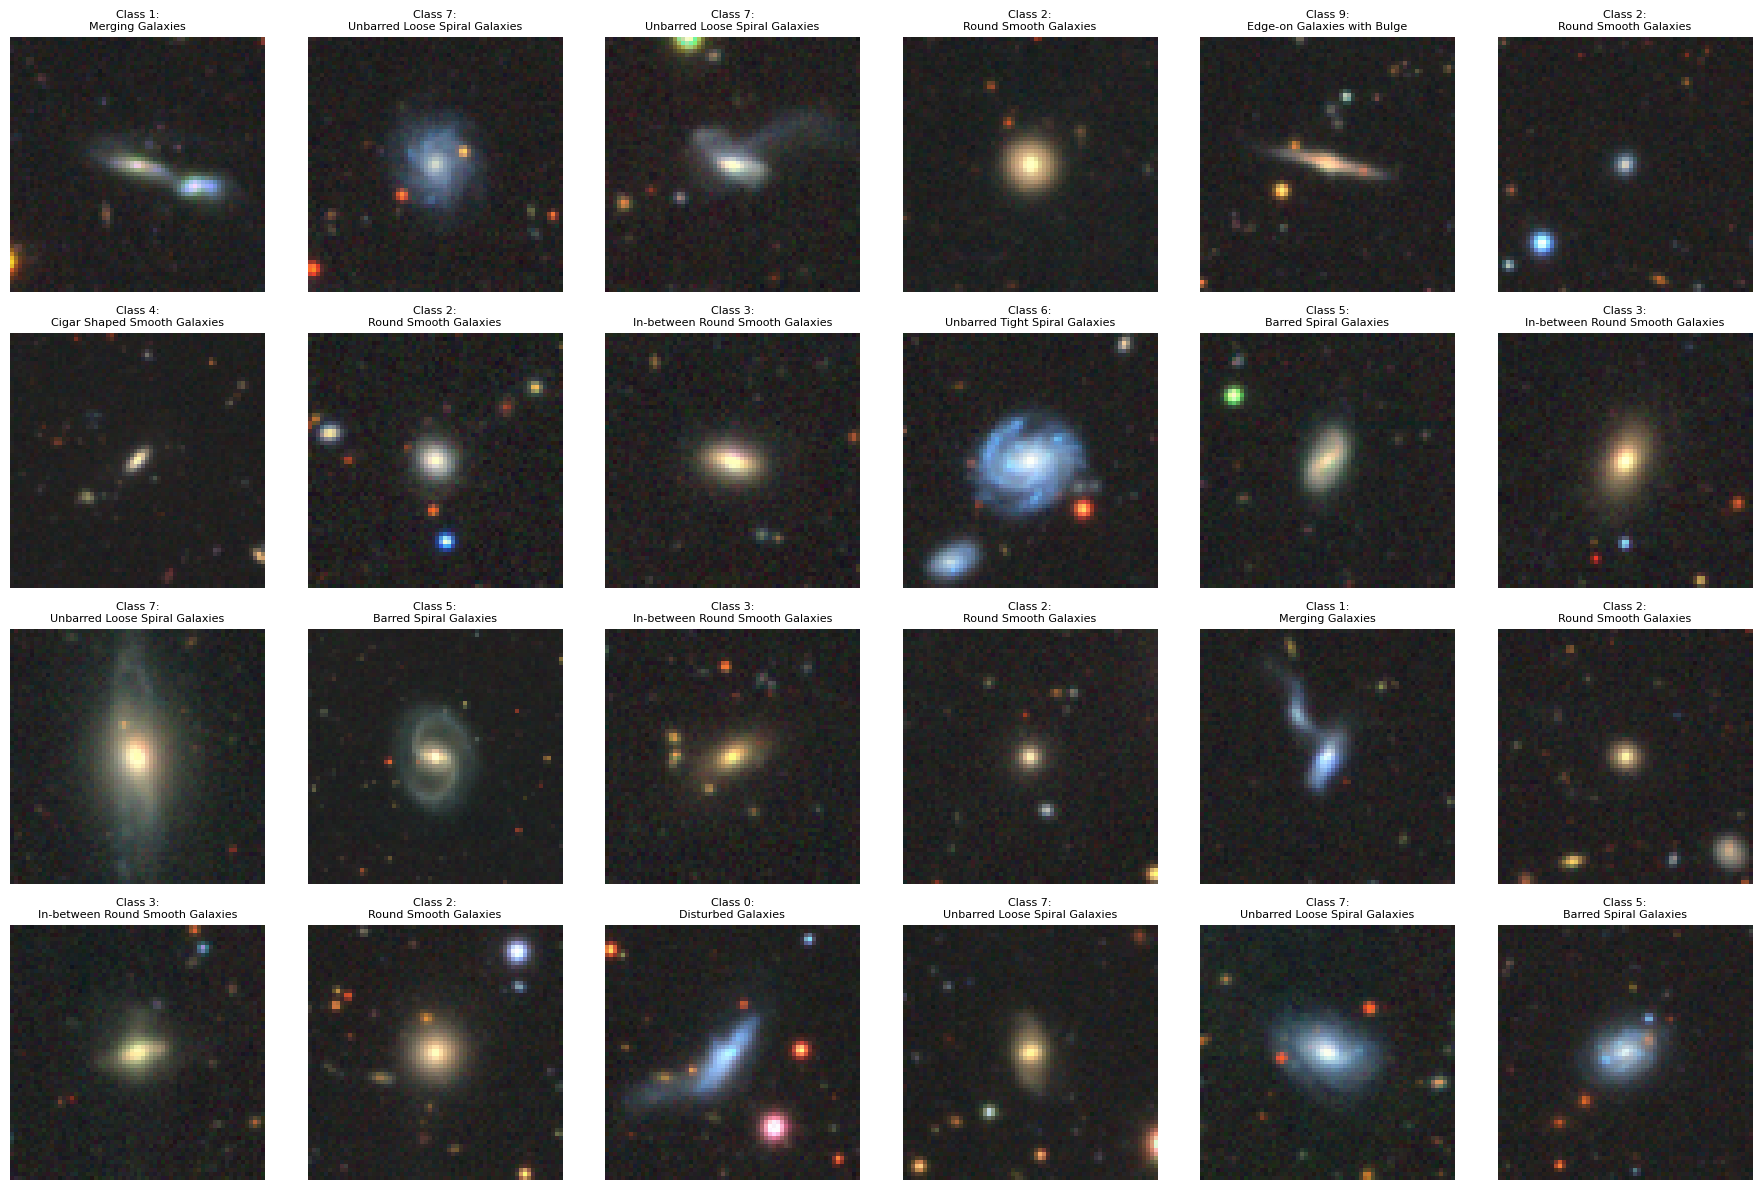

In [65]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=4, n_cols=6):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [20]:
# Create anomaly dataset: all class 4 images
ANOMALY_CLASS = 4

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 4, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (17402, 64, 64, 3)
Anomaly images: (334, 64, 64, 3)


In [21]:
# For training, remap standard labels from {0,1,2,3,5,6,7,8,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

Standard classes (original indices): [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]
Label map (original -> new): {np.uint8(0): 0, np.uint8(1): 1, np.uint8(2): 2, np.uint8(3): 3, np.uint8(5): 4, np.uint8(6): 5, np.uint8(7): 6, np.uint8(8): 7, np.uint8(9): 8}
Remapped standard labels min/max: 0 8


In [22]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

Train standard: (8701, 64, 64, 3) (8701,)
Val standard:   (4350, 64, 64, 3) (4350,)
Test standard:  (4351, 64, 64, 3) (4351,)


## 2. CNN classifier + ROC curves + confusion matrices

Steps:
- Build a CNN classifier on the **standard** dataset (9 classes)
- Train on train set, validate on val set
- Plot training history (loss & accuracy)
- Compute ROC curves (one-vs-rest) on the standard test set
- Compute confusion matrix for standard test

In [55]:
from keras.src.utils import to_categorical

# Convert labels into one-hot encoding
y_train_enc = to_categorical(y_train_std, 9)
y_val_enc = to_categorical(y_val_std, 9)
y_test_enc = to_categorical(y_test_std, 9)

print(y_train_enc[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [68]:
from keras.src.layers.activations.activation import Activation
from keras.src.layers.pooling.average_pooling2d import AveragePooling2D
from keras.src.layers.normalization.batch_normalization import BatchNormalization
from keras import layers, models

data_augmentation = models.Sequential([
    # data augmentation
    layers.RandomRotation(1.0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomContrast(0.2),
])

# CNN model for standard dataset
classifier_model = models.Sequential([

    data_augmentation,

    # first layer
    layers.Conv2D(32, (3, 3), padding="same", input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # second layer
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.2),

    # third layer
    layers.Conv2D(128, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.2),

    # classifier layer
    layers.Flatten(),
    layers.Dense(128),
    layers.Activation("relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.Dense(9, activation="softmax")
])

# compile the model
classifier_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [69]:
# model summary
print(classifier_model.summary())

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_57 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_58 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_27            │ ?                      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_59 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_28            │ ?                      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [70]:
# Train model
classifier_fit = classifier_model.fit(X_train_std, y_train_enc, epochs=50, batch_size=128,
                                      validation_data=(X_val_std, y_val_enc))

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2824 - loss: 2.1480 - val_accuracy: 0.1524 - val_loss: 2.7871
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.4274 - loss: 1.5706 - val_accuracy: 0.1517 - val_loss: 3.1877
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4649 - loss: 1.4419 - val_accuracy: 0.1520 - val_loss: 4.1148
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.5124 - loss: 1.3601 - val_accuracy: 0.1526 - val_loss: 3.1045
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5355 - loss: 1.2978 - val_accuracy: 0.1611 - val_loss: 2.8698
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.5492 - loss: 1.2407 - val_accuracy: 0.2400 - val_loss: 2.6902
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5582 - loss: 1.2021 - val_accuracy: 0.3878 - val_loss: 1.9534
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5860 - loss: 1.1677 - val_accuracy: 0.4320 - v

In [71]:
# Evaluate test set
test_loss, test_acc = classifier_model.evaluate(X_test_std, y_test_enc)
print(f"Test accuracy: {test_acc:.5f}")

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6663 - loss: 1.0055
Test accuracy: 0.68099


In [72]:
# Plot training history (accuracy and loss)
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()

    plt.show()

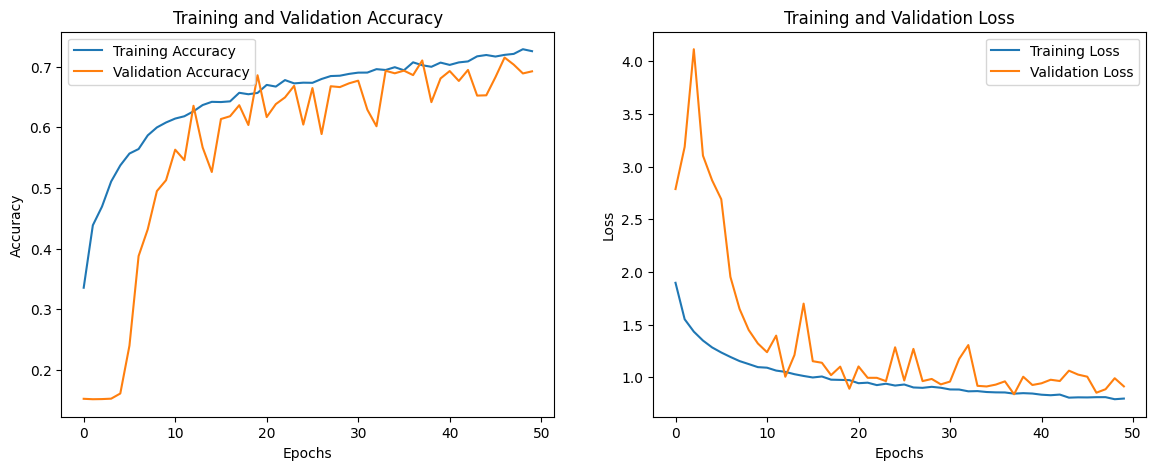

In [73]:
plot_training_history(classifier_fit)

In [74]:
# Plot ROC Curve
def plot_roc_curve(X_test, y_test, model):
    y_pred_proba = model.predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(9):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(9):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.6f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


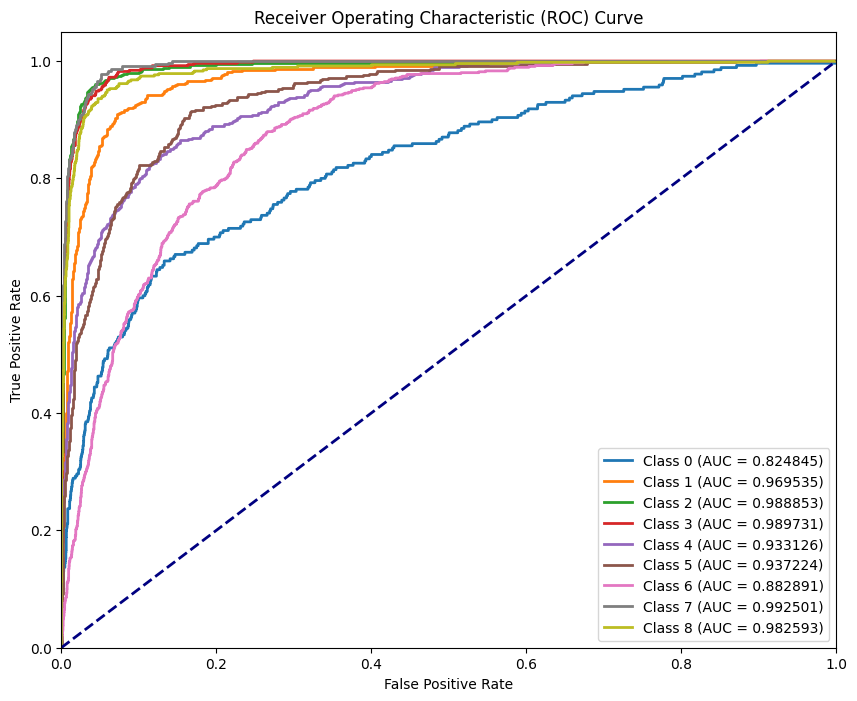

In [75]:
plot_roc_curve(X_test_std, y_test_enc, classifier_model)

In [51]:
import seaborn as sns

# Confusion Matrix
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


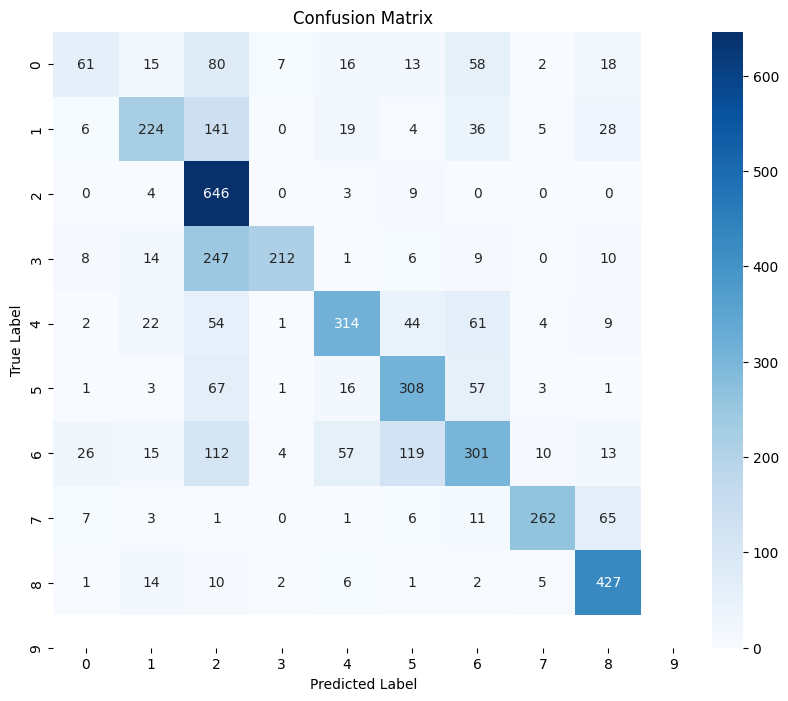

In [62]:
plot_confusion_matrix(X_test_std, y_test_enc, classifier_model)

## 3. Convolutional Autoencoder for anomaly detection

Steps:
- Train a convolutional autoencoder on **standard** train set only
- Plot training history
- Compute reconstruction loss (MSE) per image for:
  - Standard test set
  - Anomaly dataset (class 4)
- Plot histograms of reconstruction losses
- Use reconstruction loss as anomaly score and build ROC curve & confusion matrix (adapt provided code)

In [128]:
from keras.src.layers.reshaping.up_sampling2d import UpSampling2D
data_augmentation = models.Sequential([
    # data augmentation
    layers.RandomRotation(1.0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomContrast(0.2),
])

# CNN model for standard dataset
autoencoder_model = models.Sequential([
    #data_augmentation,

    # encoder
    # first encoder layer
    layers.Conv2D(64, (3, 3), padding="same", input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),

    # second encoder layer
    layers.Conv2D(32, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),

    # third encoder layer
    layers.Conv2D(16, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),

    # new representation space
    layers.Flatten(),
    layers.Dense(256),
    layers.Dense(64),
    layers.Dense(256),
    layers.Reshape((16, 16, 1)),

    # decoder
    # first decoder layer
    layers.Conv2D(8, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.UpSampling2D((2, 2)),

    # second decoder layer
    layers.Conv2D(32, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.UpSampling2D((2, 2)),

    # third decoder layer
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(3, (3, 3), padding="same", activation="sigmoid"),
])

# compile the model
autoencoder_model.compile(optimizer="adam", loss="mae", metrics=["accuracy"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [129]:
# model summary
print(autoencoder_model.summary())

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_150 (Conv2D)             │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_151         │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_153 (Activation)     │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_152         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_154 (Activation)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_153         │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_155 (Activation)     │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_153 (Conv2D)             │ (None, 16, 16, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_154         │ (None, 16, 16, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_156 (Activation)     │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_36 (UpSampling2D) │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 32, 32, 32)     │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_155         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,130,307 (4.31 MB)

 Trainable params: 1,129,875 (4.31 MB)

 Non-trainable params: 432 (1.69 KB)

None


In [130]:
# Train model
autoencoder_fit = autoencoder_model.fit(
    X_train_std,
    X_train_std,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_std, X_val_std)
    )

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - accuracy: 0.3363 - loss: 0.0937 - val_accuracy: 0.3381 - val_loss: 0.1802
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.3684 - loss: 0.0349 - val_accuracy: 0.3813 - val_loss: 0.0768
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.3802 - loss: 0.0318 - val_accuracy: 0.3769 - val_loss: 0.0512
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.3863 - loss: 0.0302 - val_accuracy: 0.3792 - val_loss: 0.0444
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.3912 - loss: 0.0292 - val_accuracy: 0.3786 - val_loss: 0.0440
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.3976 - loss: 0.0285 - val_accuracy: 0.3657 - val_loss: 0.0410
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.4004 - loss: 0.0281 - val_accuracy: 0.3779 - val_loss: 0.0371
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.4037 - loss: 0.0276 - val_accuracy: 0.3876 -

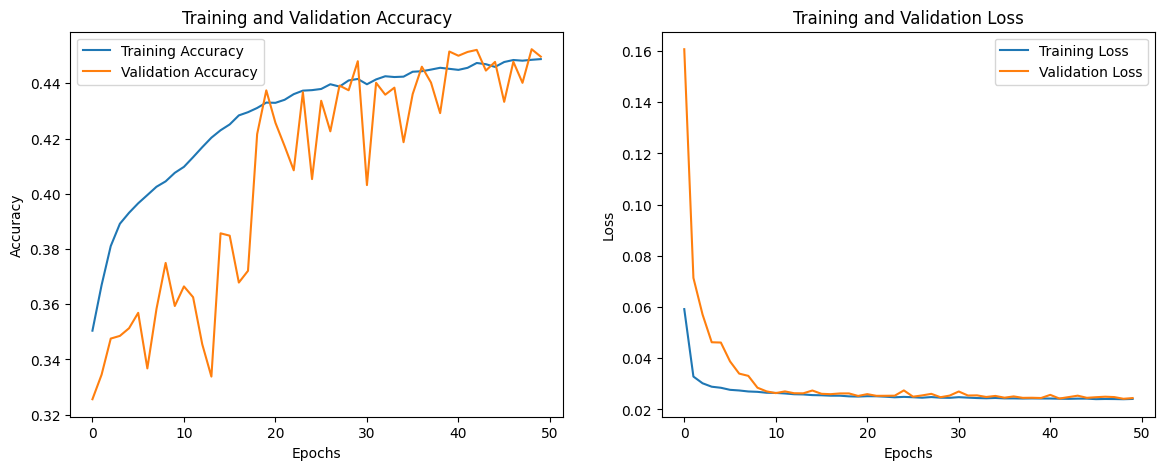

In [123]:
# plot training history
plot_training_history(autoencoder_fit)

In [133]:
# reconstruct some images
X_out_test = autoencoder_model.predict(X_test_std)
X_out_anom = autoencoder_model.predict(anom_images)

# calculate MSE
mse_test = np.mean(np.square(X_test_std - X_out_test), axis=(1, 2))
mse_anom = np.mean(np.square(anom_images - X_out_anom), axis=(1, 2))

print(f"Reconstruction loss (MSE) test set: {mse_test}")
print(f"\nReconstruction loss (MSE) anomaly set: {mse_anom}")


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Reconstruction loss (MSE) test set: [[0.00416185 0.00310238 0.00180646]
 [0.00302285 0.00210397 0.00174536]
 [0.00408151 0.00183825 0.00180764]
 ...
 [0.00302478 0.00142274 0.00124205]
 [0.00146656 0.00078469 0.00060803]
 [0.00220205 0.00138913 0.0011979 ]]

Reconstruction loss (MSE) anomaly set: [[0.00170932 0.00098281 0.00073189]
 [0.00190707 0.00077199 0.00056732]
 [0.00173874 0.00103109 0.00124531]
 ...
 [0.00157561 0.00091848 0.00109964]
 [0.00259534 0.0010151  0.00111986]
 [0.00182568 0.0007539  0.00084942]]


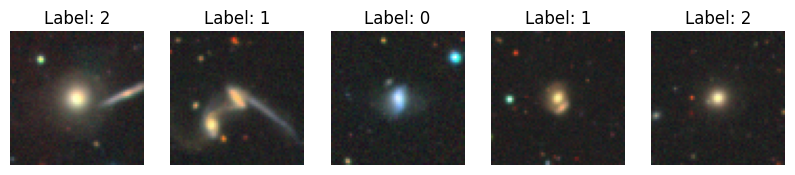

In [125]:
# Visualize data set galaxies
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(X_test_std[digits[i]])
    ax.set_title(f"Label: {y_test_std[digits[i]]}")
    ax.axis('off')
plt.show()

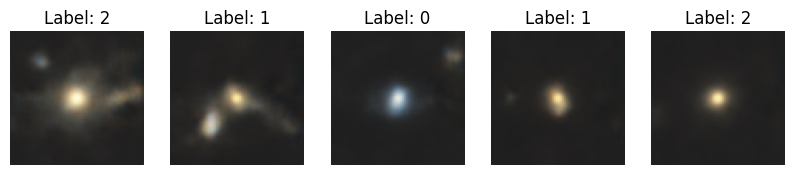

In [126]:
# Visualize reconstructed galaxies
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(X_out_test[digits[i]])
    ax.set_title(f"Label: {y_test_std[digits[i]]}")
    ax.axis('off')
plt.show()

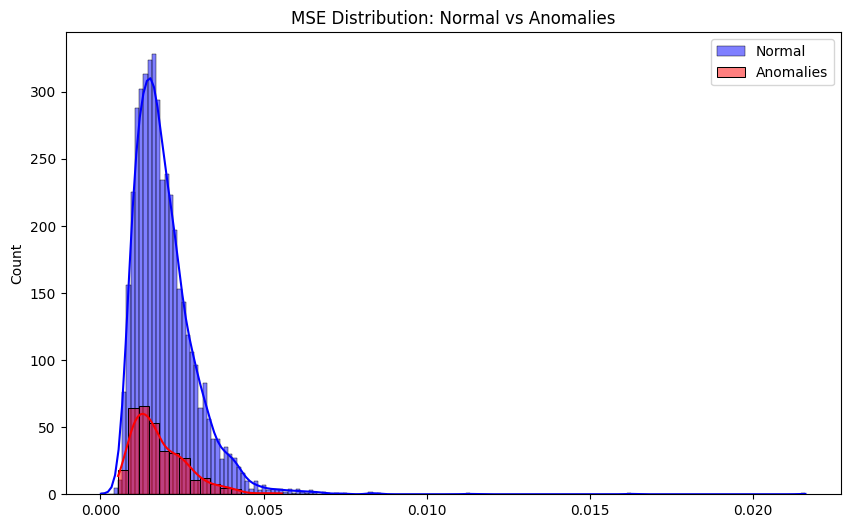

In [127]:
# Plot the distribution of MSE for normal vs anomalies
plt.figure(figsize=(10,6))
sns.histplot(mse_test, label='Normal', color='blue', kde=True)
sns.histplot(mse_anom, label='Anomalies', color='red', kde=True)
plt.title('MSE Distribution: Normal vs Anomalies')
plt.legend()
plt.show()

In [ ]:
# ROC curve
# combine normal and anomaly dataset
mse_all = np.concatenate([mse_test, mse_anom])
y_all = np.concatenate([np.zeros(len(mse_test)), np.ones(len(mse_anom))])

# compute ROC curve
fpr, tpr, thresholds = roc_curve(y_all, mse_all)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 4. Variational Autoencoder (VAE) on standard data

Steps:
- Build a VAE with convolutional encoder/decoder (trained on standard train set)
- Plot training history
- Generate new galaxy images from the VAE
- Visualize some generated images